### FreeRADIUS + Google Authenticator + AD (debian-12.5.0-amd64-netinst)

#### 1. Обновить информацию об актуальных версиях пакетов:
```
su
apt-get update
```

#### 2.  Установить пакеты:
```
apt-get install vim freeradius libpam-google-authenticator ntp
```

> Настройка `ntp`
```
#systemctl enable --now ntpsec
systemctl status ntp
vim /etc/ntpsec/ntp.conf
```

#### 3. Включить модуль аутентификации PAM
```
vim /etc/freeradius/3.0/sites-enabled/default
```
Должно получиться так:
```
# Pluggable Authentication Modules.
pam
```

#### 4. Проверить наличие модуля PAM

```
cd /etc/freeradius/3.0/mods-enabled
```

Если модуля нет, то создать символическую ссылку:
```
ln -s /etc/freeradius/3.0/mods-available/pam /etc/freeradius/3.0/mods-enabled/pam
```

#### 5. Указать Auth-Type
```
vim /etc/freeradius/3.0/users
```

После блока `# Deny access for a group of users` добавить:
```
DEFAULT        Group == "radius-disabled", Auth-Type := Reject
               Reply-Message = "Your account has been disabled."

DEFAULT Auth-Type := PAM
```

#### 6. Редактируем файл, чтобы FreeRADIUS использовал учётную запись с правами администратора

> `vim /etc/systemd/system/multi-user.target.wants/freeradius.service`

```
User=freerad
Group=freerad

Заменяем на:

User=root
Group=root
```

> `vim /etc/freeradius/3.0/radiusd.conf` (поиск: `:/user =`)
```
user = freerad
group = freerad

Заменяем на:

user = root
group = root
```

#### 7. Перезапустить `freeradius.service`:
```
systemctl daemon-reload
```
```
systemctl restart freeradius
```
```
systemctl status freeradius
```

#### 8. Проверка для локального пользователя без Google Authenticator

> Для проверки правильности конфигураций:
```
radtest <username> <пароль><6-значный код из приложения Google Authenticator> localhost 1812 testing123
```

```
radtest user1 P@ssw0rd localhost 1812 testing123
```

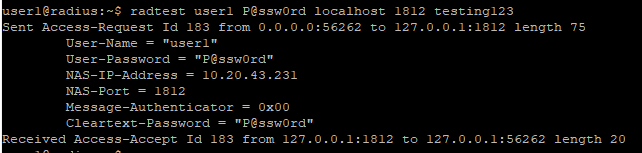

---

#### 1. Установка LDAPD
```
apt-get install libnss-ldapd libpam-ldapd
```

> URI of LDAP server: `ldap://ldap-srv.example.com`;
```
ldap://10.20.43.221
```
> LDAP server search base: `dc=example`,`dc=com`;
```
dc=test,dc=ad
```
> Имена настраиваемых служб: `passwd`, `group`, `shadow`, `netgroup`.




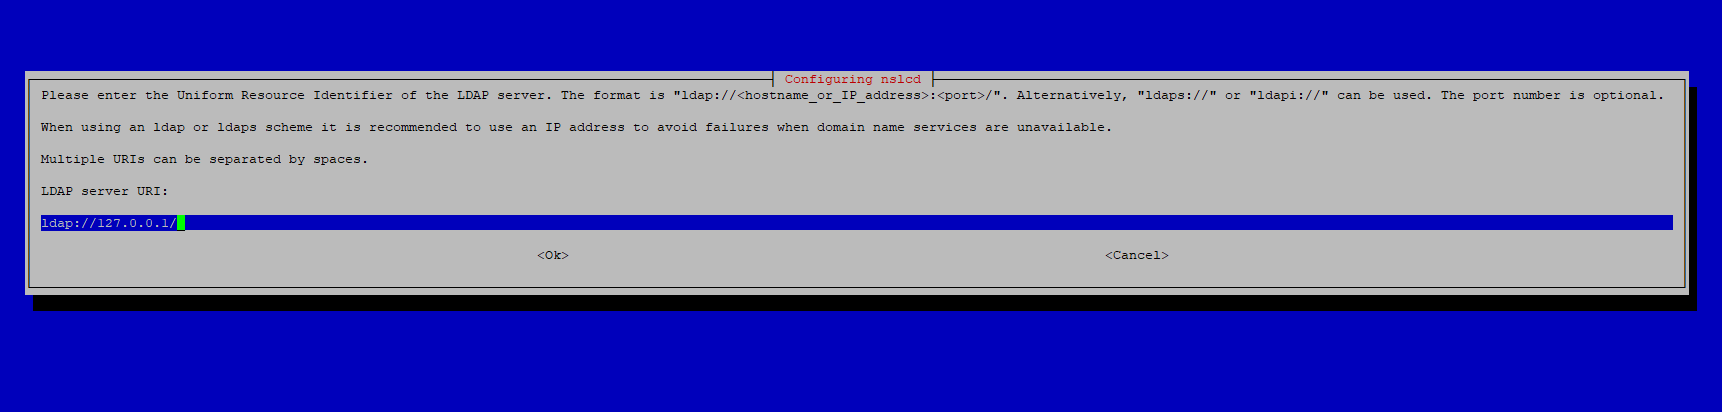

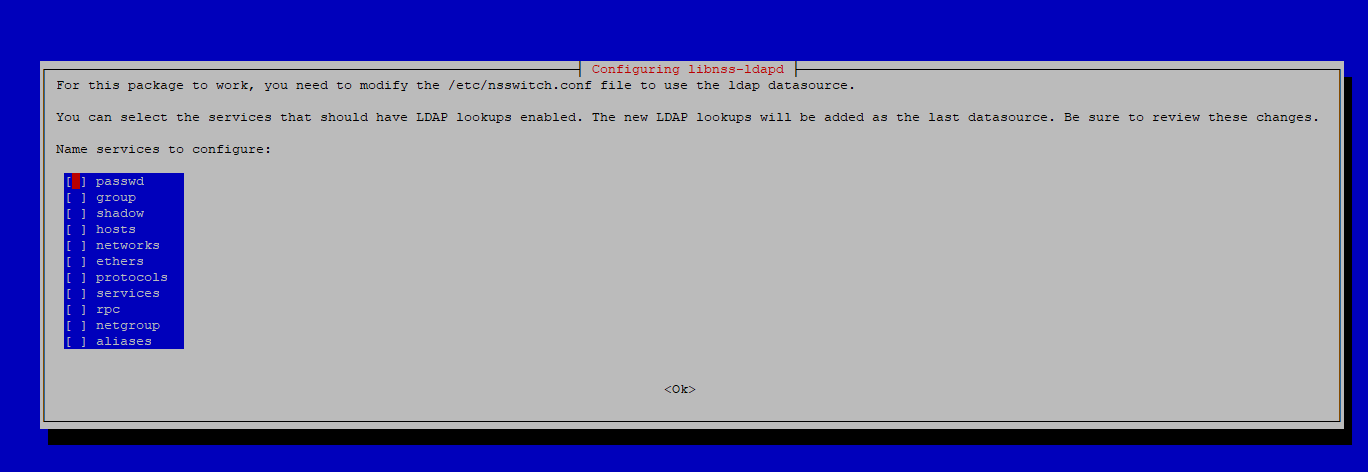

#### 2. Создание пользовательских директорий на стороне RADIUS-сервера

> Редактируем файл:
```
vim /etc/pam.d/common-session
```

> Добавляем в конец файла:
```
# make home directories
session required pam_mkhomedir.so skel=/etc/skel/ umask=0077
```

#### 3. Конфигурируем LDAPD

#### 3.1. `nsswitch.conf` (`vim /etc/nsswitch.conf`)
```
passwd: compat ldap
group: compat ldap
shadow: compat ldap
gshadow: files

hosts: files dns ldap
networks: files

protocols: db files
services: db files
ethers: db files
rpc: db files

netgroup: nis
```

#### 3.2. `nslcd.conf` (`vim /etc/nslcd.conf`)
```
# The user and group nslcd should run as.
uid nslcd
gid nslcd

# The location at which the LDAP server(s) should be reachable.
uri ldap://10.20.43.221

# The search base that will be used for all queries.
base dc=test,dc=ad

# The LDAP protocol version to use.
ldap_version 3

# The DN to bind with for normal lookups.
binddn kate4@test.ad
bindpw Password123$

# SSL options
ssl off
tls_reqcert never
tls_cacertfile /etc/ssl/certs/ca-certificates.crt
# The search scope.
scope sub
```

> Mapping for Active Directory

```
# replace the SIDs in the objectSid mappings with the value for your domain
pagesize 1000
referrals off
idle_timelimit 800
filter passwd (&(objectClass=user)(objectClass=person)(!(objectClass=computer)))
map passwd uid cn
map passwd uidNumber objectSid:S-1-5-21-3997609503-992433755-1954237486
map passwd gidNumber objectSid:S-1-5-21-3997609503-992433755-1954237486
map passwd homeDirectory "/home/$cn"
map passwd gecos displayName
map passwd loginShell "/bin/bash"
filter group (|(objectClass=group)(objectClass=person))
map group gidNumber objectSid:S-1-5-21-3997609503-992433755-1954237486
```

_______

`objectSid`: S-1-5-21-3997609503-992433755-1954237486
_______

#### 3.3. `nscd.conf` (`vim /etc/nscd.conf`)

Отключить кеширование:
```
enable-cache no
```

#### 4.  Перезагружаем сервер
```
systemctl reboot
```

#### 5. Редактируем файл для комбинирования пользовательских паролей и кодов, генерируемых Google Authenticator
```
vim /etc/pam.d/radiusd
```

> Закомментировать эти строки:
```
#@include common-auth
#@include common-account
#@include common-password
#@include common-session
```
> Добавить эти строки (`Shift`+`Insert`):
```
auth requisite pam_google_authenticator.so forward_pass debug
auth [success=2 default=ignore] pam_ldap.so minimum_uid=1000 use_first_pass debug
auth [success=1 default=ignore] pam_unix.so nullok_secure debug
auth requisite pam_deny.so
auth required pam_permit.so
```

#### 6. Получаем Google Authenticator
Создание нового пользователя не требуется, т.к. аутентификация происходит через домен. Все необходимые подготовительные действия – создание пользовательской директории – будут выполнены в момент первого входа на RADIUS-сервер.
> Входим под пользователем домена:
```
login as: <domain_user>
password: <your_password>
```
> Проверяем, что мы оказались в своей директории.

> Создаем идентификатор:
```
google-authenticator
```

#### 7. Проверка для локального пользователя с Google Authenticator

```
radtest user1 P@ssw0rd101090 localhost 1812 testing123
```

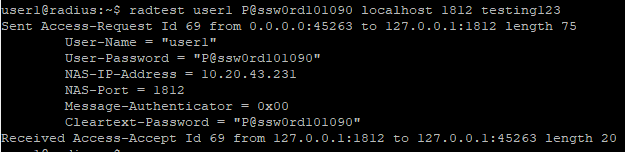

#### 8. Проверка для доменного пользователя

```
radtest kate2 Password123152371 localhost 1812 testing123
```

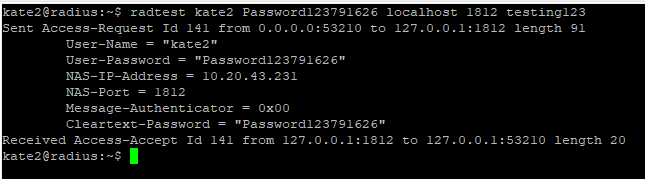

___

> Запустить FreeRADIUS в режиме отладки
```
systemctl stop freeradius

/usr/sbin/freeradius -X
```

> Добавить клиента RADIUS-сервера

Клиенты — рабочие станции и серверы, которые проходят аутентификацию через RADIUS-сервер.

Редактируем файл:
```
vim /etc/freeradius/3.0/clients.conf
```

```
Client clnt-name {
    secret = testing123
    shortname = clnt-name
    ipaddr = 10.20.43.221
}
```
`ipaddr` - ip-адрес RADIUS-клиента,
`secret` - для проверки разрешения на аутентификацию.

> Настройки сети

```
vim /etc/resolv.conf
```

```
vim /etc/network/interfaces
```
```
systemctl restart networking
```